In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from torch.utils.data import TensorDataset


%matplotlib inline

olivetti = fetch_olivetti_faces()
images = olivetti.images
labels = olivetti.target

Let me show 40 different people.
images shape: (400, 64, 64), labels shape: (400,)


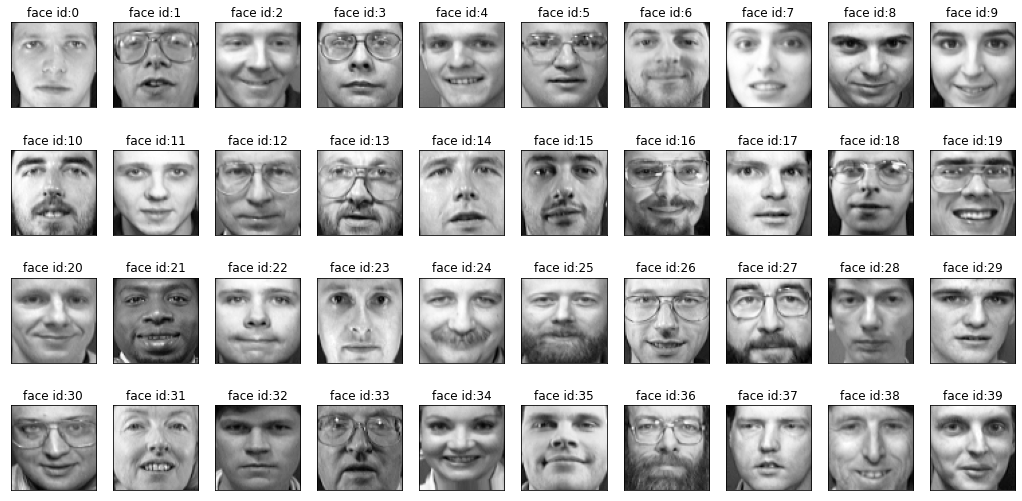

In [2]:
def show_40_distinct_people(images, unique_ids):
    #Creating 4X10 subplots in  18x9 figure size
    fig, axarr=plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    #For easy iteration flattened 4X10 subplots matrix to 40 array
    axarr=axarr.flatten()
    
    #iterating over user ids
    for unique_id in unique_ids:
        image_index=unique_id*10
        axarr[unique_id].imshow(images[image_index], cmap='gray')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(unique_id))
        
print(f"Let me show {len(np.unique(labels))} different people.")
show_40_distinct_people(images, np.unique(labels))

print(f"images shape: {images.shape}, labels shape: {labels.shape}")

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, random_state=0,
                                                   stratify=labels, test_size=0.1)

print(len(X_train), len(X_test))

360 40


In [4]:
import torch
from torch import nn, optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import PIL

In [5]:
compose = transforms.Compose([
    transforms.ToPILImage(), 
    torchvision.transforms.RandomHorizontalFlip(),transforms.RandomAffine(5),
    transforms.transforms.RandomRotation(40, resample=PIL.Image.BILINEAR),
    transforms.ToTensor() 
])

In [6]:
compose

Compose(
    ToPILImage()
    RandomHorizontalFlip(p=0.5)
    RandomAffine(degrees=(-5, 5))
    RandomRotation(degrees=(-40, 40), resample=2, expand=False)
    ToTensor()
)

In [7]:
# define FaceDataset
class FaceDataset(Dataset):
    def __init__ (self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    def __getitem__(self,idx):
        label = self.labels[idx]
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return [image, label]
x=FaceDataset(X_train,y_train,transform= compose)

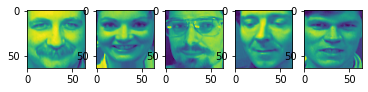

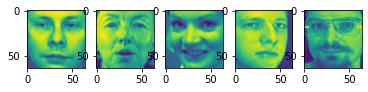

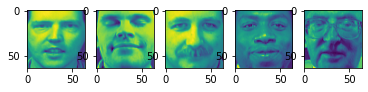

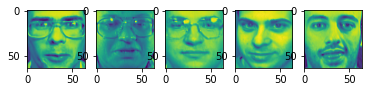

In [8]:
fig,ax = plt.subplots(nrows=1,ncols=5)
for i in range(5):
    ax[i].imshow(X_train[i+10])
fig,ax = plt.subplots(nrows=1,ncols=5)
for i in range(5):
    ax[i].imshow(X_train[i+20])
fig,ax = plt.subplots(nrows=1,ncols=5)
for i in range(5):
    ax[i].imshow(X_train[i+30])
fig,ax = plt.subplots(nrows=1,ncols=5)
for i in range(5):
    ax[i].imshow(X_train[i+40])

In [9]:
X_train[1]

array([[0.3305785 , 0.35123968, 0.3677686 , ..., 0.3429752 , 0.40082645,
        0.40495867],
       [0.35123968, 0.39256197, 0.40495867, ..., 0.3677686 , 0.3966942 ,
        0.3181818 ],
       [0.37190083, 0.39256197, 0.4338843 , ..., 0.40495867, 0.37603307,
        0.23140496],
       ...,
       [0.28099173, 0.69008267, 0.6446281 , ..., 0.6198347 , 0.7933884 ,
        0.73140496],
       [0.446281  , 0.74793386, 0.6942149 , ..., 0.60330576, 0.7644628 ,
        0.75619835],
       [0.57438016, 0.75619835, 0.7066116 , ..., 0.59917355, 0.73966944,
        0.78512394]], dtype=float32)

In [10]:
# convert 
for i in range(360):
    X_train = np.append(X_train, x[i][0], axis=0)
    y_train = np.append(y_train, x[i][1])

C:\Users\goran\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


In [11]:
X_train=X_train.reshape(720,1,64,64)

In [12]:
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
train_data = TensorDataset(X_train,y_train)
train_loader=DataLoader(train_data,batch_size=32, shuffle=True)
X_test , X_test,y_test =X_test.reshape(40,1,64,64),torch.from_numpy(X_test),torch.from_numpy(y_test)
test_data = TensorDataset(X_test,y_test)

In [13]:
test_loader = DataLoader(test_data,batch_size=32,shuffle=False)

In [14]:
X_train.shape

torch.Size([720, 1, 64, 64])

In [15]:
import torch
import torch.nn as nn 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777) # 기본 torch 의 random 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777) # gpu 사용시 random 고정

In [16]:
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [34]:
class FaceClassifier(nn.Module):
    def __init__(self):
        super(FaceClassifier, self).__init__()
        self.layer1 = torch.nn.Sequential(
        torch.nn.Conv2d(1,10,kernel_size=3, stride=1,padding=1), # 처음 input 은 1
        torch.nn.ReLU(),
        torch.nn.Conv2d(10,10,kernel_size=3, stride=1,padding=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(10,10,kernel_size=3, stride=1,padding=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(10,10,kernel_size=3, stride=1,padding=1),
        torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = torch.nn.Sequential(
        torch.nn.Conv2d(10,20, kernel_size=3, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(20,10, kernel_size=3, stride=1, padding=1),
        torch.nn.MaxPool2d(kernel_size=4, stride=2))
        self.fc1 = torch.nn.Linear(2250,400)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.fc2 = torch.nn.Linear(400,40)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [37]:
model = FaceClassifier()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [39]:
total_batch = 23
for epoch in range(15):
    avg_cost = 0
    for X,Y in train_loader:
        X = X.reshape(-1,1,64,64)
        Y=Y.long()
        optimizer.zero_grad()
        hypothesis=model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()
        avg_cost += cost / total_batch
    print('Epoch is {} cost is {}'.format(epoch+1,avg_cost))

[Epoch:    1] cost = 6.399189
[Epoch:    2] cost = 4.01351547
[Epoch:    3] cost = 3.86686087
[Epoch:    4] cost = 3.78934693
[Epoch:    5] cost = 3.74038029
[Epoch:    6] cost = 3.74287462
[Epoch:    7] cost = 3.72414708
[Epoch:    8] cost = 3.72449708
[Epoch:    9] cost = 3.74101543
[Epoch:   10] cost = 3.753438
[Epoch:   11] cost = 3.73885798
[Epoch:   12] cost = 3.73501134
[Epoch:   13] cost = 3.72280502
[Epoch:   14] cost = 3.7122407
[Epoch:   15] cost = 3.72193193
Learning Finished!


In [45]:
with torch.no_grad():
    model.eval()
    X_test = X_test.reshape(-1,1,64,64)
    Y_test = y_test
    prediction = model(X_test) 
    correct_prediction = torch.argmax(prediction,1)== Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy: ', accuracy.item())
    
# 아니 왜 accuracy 가 0.025 가 나오는지 모르겠습니다.
# 아마 모델이 훈련이 안됬나봐요.. 1/40이 0.025 이니까요. 다만 어느부분에서 이런값이 나왓는지는모르겠습니다.

Accuracy:  0.02500000037252903
